<h3><i>Introduction, Motivation and Predictions</i></h3><br>
We will take a look at the data for the passengers for the RMS Titanic, which hit an iceberg and sank in April 15, 1912, leading many, but not all passengers to perish as there were not enough lifeboats to carry all passengers.  We will look into the various factors that might have lead to a greater or lesser chance of surviving.  We will take a close look at the sex (or gender), the age, the number of parents/children, and the ticket, and also look at the passengers that held a that ticket that was shared with a survivor.<br>

The motivation for this focus on passengers sharing a ticket with a survivor came after taking a quick look at some data on Wikipedia (https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic).  We saw this small sample of data below, with the survivors in blue in those who perished in grey:

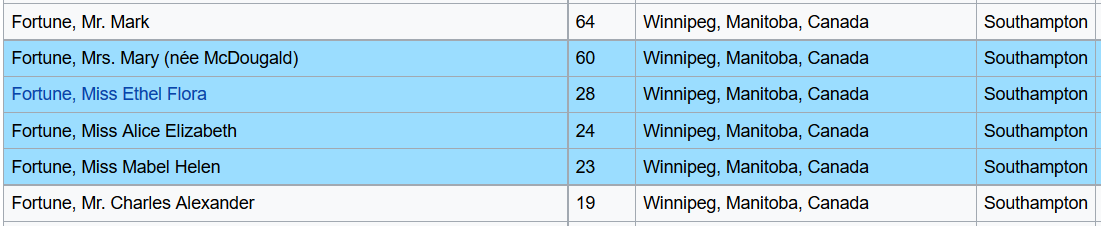

In [1]:
from IPython.display import Image
Image("img/passengers_wikip.png")

<i>So in this group, we had all four female passengers survive, and both male passengers did not.  This suggested the hypotheses that we take up in this report.</i>   First, among those passengers that were in the same family group (including those servants and friends with the family), we expect females to have a very high survival rate, certainly higher than the baseline rate for all female passengers.  Next, we expect males in the same groups should have an exceptional low survival rate.  Then we make some more speculative predictions for what might lead to these rates, based on the possibility that passengers sharing a ticket with a survivor had an option to board but may have chosen not to, in order to follow the <i>"women and children first" principle</i> which dictates that women and children should be saved before adult males. <br>

Obviously the "women and children first" norm would explain much of the data showing higher survival rates for females.  But we would not guess that every male in a family group would give up their chance for survival, even in the unlikely event that all or most men wanted to adhere to the "women and children first" rule.  After all, boys would be exempt under "women and children".  But adult men, especially older men would not be exempt.  Specifically, we predict that the oldest male in family unit would be especially likely to give up his chance at survival.  Also, we guess, without much to base this guess on, that larger family units would show a higher likelihood of men giving up a seat on a lifeboat.  After all, with a larger number of women and children in their family taking up seats that other families want, there be an extra pressure for the males to give up their seat. <br>

The Wikipedia data looks like it was grouped together based on shared name + shared home town (Winnipeg) as well as shared embarkation city (Southampton).  The Kaggle data we have do not have the shared home town, only the name and the embarkation city.  We don't want to guess that those with the same last name and embarkation city are in the same group because it could easily happen that two different families with the same common last name would embark from the same city.  But it seems safe to assume that those passengers under the same ticket are a unit.  So we will look at passengers sharing the same ticket, paying special attention to passengers sharing a ticket with another passenger who survived.  <br><br>
<i>The specific predictions are:</i> <br>
<li>Males would have lower survival rate than women (based on "women and children first")
<li>Children would have higher survival rates than adults (also based on "women and children first")
<li>Men sharing a ticket with a survivor would have very low survival rates.
<li>Females sharing a ticket with a survivor would have a very high survival rate.
<li>The oldest males in a ticket group would have a low survival rate (compared to all male passengers sharing a ticket), especially the males sharing a ticket with a survivor.
<li>The men sharing a ticket with many passengers would have a lower survival rate (compared to all male passengers sharing a ticket).
<li>The men with a larger number of children who share a ticket with a survivor would have a low survival rate (compared to all men sharing a ticket with a survivor).

<h3><i>Set up for charts and statistics code</i></h3> <br>

<i>We now process the data and set up the code for statistics and chart read outs.</i>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%pylab inline

titanic_df = pd.read_csv('titanic-data.csv')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_surv_rate(df):
    return df['Survived'].sum(), df['Survived'].count(), (df.Survived.sum() / df['Survived'].count() )

get_surv_rate(titanic_df)

(342, 891, 0.38383838383838381)

NOTE: for the above application of get_surv_rate utility we will use, we see from output (<i>342</i>, <i>891</i>, <i>0.38383838383838381</i>):<br>
<i>342</i>: # of survivors in the dataframe
<br><i>891</i>: # of total passengers in the dataframe
<br><i>0.38383838383838381</i>: survival rate as ratio of these two values
<br>
<b><i>This format will be used in the stats read outs.</i></b>

In [4]:
def ticket_related_grps(df):
    
    num_in_ticket_results = [] # the number of passengers besides the passenger sharing the passenger's ticket
    surv_ticket_results = []   # whether the passenger is sharing a ticket with a survivor
    oldest_results = []        # whether the passenger is an adult male and also the oldest male with at least one other passenger sharing ticket       
    
    for index, row in df.iterrows():
        passid = row['PassengerId']
        ticket = row['Ticket']
        age = row['Age']
        sex = row['Sex']
        ticket = row['Ticket']
            
        query = 'Ticket == \"{}\" & PassengerId != {}'.format(ticket, passid)
        result = df.query(query)
        num_in_ticket_results.append(map_numticket_to_grp(len(result))) # get the # passengers w/ diff ID sharing the ticket
        
        if len(result) == 0:               # not counted as oldest male or sharing ticket with survivor if not sharing a ticket
            oldest_results.append(0) 
            surv_ticket_results.append(0)
        else:
            if len(result.query('Survived == 1')) > 0: # if other passenger sharing ticket survived
                surv_ticket_results.append(1)
            else:
                surv_ticket_results.append(0)
                
            if sex == "female" or math.isnan(age) or age < 16:  # if female or have NaN age, not counted as oldest male
                oldest_results.append(0)
            elif len(result.query('Sex == \"male\" & Age >= {}'.format(age))) > 0: # same if other older male is sharing ticket
                oldest_results.append(0)
            else:
                oldest_results.append(1) # if none of the above 2 conditions, count as the oldest male  
                
    df['num_in_ticket'] = num_in_ticket_results
    df['surv_ticket'] = surv_ticket_results
    df['oldest_male'] = oldest_results

def map_numticket_to_grp(num_in_ticket):
    if num_in_ticket == 0 or num_in_ticket == 1:
        return num_in_ticket
    elif num_in_ticket == 2 or num_in_ticket == 3:
        return 2
    else:
        return 3

ticket_related_grps(titanic_df)

In [5]:
def age_group(age):
    if isnan(age):
        return "Unknown"
    elif age >= 0 and age < 5:
        return "00-04"
    elif age >= 5 and age < 10:
        return "05-09"
    elif age >= 10 and age < 15:
        return "10-14"
    elif age >= 15 and age < 20:
        return "15-19"
    elif age >= 20 and age < 25:
        return "20-24"
    elif age >= 25 and age < 30:
        return "25-29"
    elif age >= 30 and age < 40:
        return "30-39"
    elif age >= 40 and age < 50:
        return "40-49"
    else:
        return "50+"
    
titanic_df['age_grp'] = titanic_df['Age'].apply(age_group)

In [6]:
# Creating groups to facilitate inferences on effects of increasing # parents/children. 
# Since relatively few passengers (less than 11%) have 2+ parents/children, we don't want to
# further split up this group, so we make 2+ its own group along with groups for 0 and 1 parents/children
def map_parch(num):
    if num == 0:
        return 0
    elif num == 1:
        return 1
    else:
        return 2

titanic_df['parch_grp'] = titanic_df['Parch'].apply(map_parch)
titanic_df.groupby('parch_grp').apply(get_surv_rate)

parch_grp
0    (233, 678, 0.343657817109)
1     (65, 118, 0.550847457627)
2      (44, 95, 0.463157894737)
dtype: object

The next block of code is to set up my own chi-square test.  Motivation: without being very savy with statistics and the assumptions that go with each statistic and tool, I am going to err on the side of caution and not apply the statistical test to claim statistical significance when there is any reason not to do so.  In the chi-square test I will exit if there are any cells in the contingency table with less than 5 members, as per some recommendations (with others recommending that it might be ok if only 20% of cells contain less than 5).  <br>

This is to test for independence of the survival data (the "Survived" column) and the factor in question.  If there is a dependence, then the factor can arguably be used to predict chances of survival. <br>

Some caveats: chi-square test should be used with categorical data, but in many cases I am dealing with numerical data (age or number of siblings and spouses), which are sometimes binned together into groups, and this loses information which could be used to reject the null hypothesis.  Since we might be losing information that could help us reject the null hypothesis, this is another way that we are being conservative.  One more caveat applied to most statistics: it should be based on random sampling of independent events; but we know these events were not dependent because there were at minimum sequential dependencies, with passenger lifeboats having to wait for lifeboats ahead in the line; and more importantly, one person's survival probably decreases the chances of another's survival, since there were a limited number of passengers that could board.<br>

<i>The statistics and the raw group-by numbers and the bar charts are meant to be taken in together to get a feel for the likely importance of a variable like age to the chances for survival.</i>

In [7]:
# Upper and lower tail critical values of chi-square distribution with 1,2,3,..,10 degrees of freedom for alpha/2 = 0.025
# source: http://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm
thresholds_up = [5.024, 7.378, 9.348, 11.143, 12.833, 14.449, 16.013, 17.535, 19.023, 20.483]
thresholds_down = [0.001, 0.051, 0.216, 0.484, 0.831, 1.237, 1.690, 2.180, 2.700, 3.247]

def chisquare_like_stats(df, factor):
    
    """  NOTE: This is 2 tailed chi-squared independence test for only for one factor and survival rates
        to test for independence of the factor and the Survived (0 or 1) results.
        In other words, are the 0s and 1s for Survived independent of the levels for this one factor?
        Example: For Pclass, do the different classes have different distribution of survivals, i.e. different survival rates?
        Algorithm taken from contingency table calculation in https://onlinecourses.science.psu.edu/stat500/node/56  
        No calculations run if one cell in contingency table calulation has less than 5 members.
    """
    grp = df.groupby(factor).apply(get_surv_rate)
    survs = [ grp[ind][0] for ind in grp.index ]
    totals = [ grp[ind][1] for ind in grp.index ] 
   
    avg = sum(survs) / sum(totals)
    totalsums = 0
    for i in range(len(totals)): 
        # insure there are at least 5 entries in each cell in contingency table before testing
        if survs[i] < 5 or (totals[i]-survs[i]) < 5:
            return (False,False,0,0,0) # Not significant, Not enough data, and statistic and both thresholds defaulted to 0
        
        exp_surv = int(avg * totals[i])
        num_surv = survs[i]
        exp_no_surv = (totals[i] - exp_surv)
        num_no_surv = totals[i] - num_surv
        totalsums += ( (num_surv - exp_surv)**2 / exp_surv )
        totalsums += ( (num_no_surv - exp_no_surv)**2 / exp_no_surv )
    deg_freedom = len(totals) - 1   # 2 levels for Survived and N levels for the factor -> degrees freedom = N-1
    thresh_up = thresholds_up[deg_freedom-1] 
    thresh_down = thresholds_down[deg_freedom-1]
    
    # statistically significant if sum squares >= upper threshold or <= lower threshold
    return ((totalsums>=thresh_up or totalsums<=thresh_down), True, totalsums, thresh_up, thresh_down) # significant if totalsums>=thresh, and True for enough data to test


def factor_statist_signif(df, factor):
    return chisquare_like_stats(df, factor)[0]

def print_stats(df, factor):
    print("Printing stats for factor: {}".format(factor))
    stats_output = chisquare_like_stats(df, factor)
    if not stats_output[1]:
        print("Not enough data")
    elif stats_output[0]:
        print("Factor {} statistically signif, test statistic: {:.2f}, upper threshold: {:.2f}, lower threshold: {:.2f}".
              format(factor, stats_output[2], stats_output[3], stats_output[4]))
    else:
        print("Factor {} NOT statistically signif, {:.2f} < {:.2f} and {:.2f} > {:.2f}".
              format(factor, stats_output[2], stats_output[3], stats_output[2], stats_output[4]))
        
for column in titanic_df.columns:
    stats_output = chisquare_like_stats(titanic_df, column)
    if stats_output[0]: # boolean, if the psuedo-chi-square test shows statistical significance
        print("Factor {} statistically signif, {:.2f} >= {:.2f} or {:.2f} <= {:.2f}".
              format(column, stats_output[2], stats_output[3], stats_output[2], stats_output[4]))

Factor Pclass statistically signif, 105.02 >= 7.38 or 105.02 <= 0.05
Factor Sex statistically signif, 264.22 >= 5.02 or 264.22 <= 0.00
Factor Embarked statistically signif, 26.81 >= 7.38 or 26.81 <= 0.05
Factor num_in_ticket statistically signif, 85.11 >= 9.35 or 85.11 <= 0.22
Factor surv_ticket statistically signif, 132.07 >= 5.02 or 132.07 <= 0.00
Factor oldest_male statistically signif, 13.34 >= 5.02 or 13.34 <= 0.00
Factor age_grp statistically signif, 25.71 >= 19.02 or 25.71 <= 2.70
Factor parch_grp statistically signif, 21.78 >= 7.38 or 21.78 <= 0.05


<br><br>
<i>Next we want to create some functions that will flexibly handle various conditions to output bar charts</i> for a single factor or two factor chart which shows the survival rates for each level of the factor(s).  In other words, <i>we don't want to have write one block of code to get a chart adjusted for three levels and one factor name and then have to write a new block of code for another factor name with 6 levels.</i>  We want to get the factor name either through input (for example, "gender") or through the group-by index (or multi-index) if that is not given.  We want to find the number of ticks and legend levels needed automatically also from the index, or optionally from user input.

In [8]:
_FigureNum = 1   # global variable (booo!) for automatically updating the figure number for the charts

def groupby_barplot(groupby_series, grp_name=None, grpLabels=None, sample_pop=None):
    
    """This method will make a bar plot for survival rate for a single factor group-by.
    The user has the option of specifying the factor name (i.e. 'Gender') in grp_name
    and/or the list of factor labels (i.e. ['Male', 'Female']) under grpLabels, both 
    of which are displayed on the x-bar. If the user does not specify these then we 
    use the index name and levels."""
    
    objects = grpLabels if grpLabels!=None else list(groupby_series.index) 
    group_name = grp_name if grp_name!=None else groupby_series.index.name # if no factor given, find it in the index
    x_pos = np.arange(len(objects))
    data = list(groupby_series)
     
    plt.bar(x_pos, data, align='center', alpha=0.5)
    plt.xticks(x_pos, objects)
    plt.xlabel(group_name)
    plt.ylabel('Survival Rate')
    plt.ylim(0.0, 1.0)
    
    global _FigureNum
    if sample_pop != None:
        title = 'Figure {}: Survival Rate by {} for {}'.format(_FigureNum, group_name, sample_pop)
    else:
        title = 'Figure {}: Survival Rate by {}'.format(_FigureNum, group_name)
    _FigureNum += 1
    plt.title(title)
    
def df_groupby_barplot(df, factor, grp_name=None, grpLabels=None, sample_pop=None):
    
    """This method will call groupby_barplot to make a bar plot for survival rate after
    getting the groupby for the given df and single factor."""
    
    grp = df.groupby(factor)['Survived'].mean()
    groupby_barplot(grp, grp_name=grp_name, grpLabels=grpLabels, sample_pop=sample_pop)


In [9]:
def groupby2_barplot(groupby_series, grp1Name = None, grp1Labels=None, grp2Name=None, 
                     grp2Labels=None, sample_pop=None):
    
    """This method will create a bar plot of survival rate for a 2 factor group-by.
    The user has the option of specifying the name and labels to be displayed on the x-axis
    and the legend.  If they are not given, we use the index names and levels.
    Typically the groupby_series will be passed in from a 
    df.groupby(['grp1Name', 'grp2Name']).apply(get_surv_rate) call.
    Finding the means every possible level combination for both factors could result in a KeyError, so we
    catch the KeyError and then use a no-length bar for that tick.  
    NOTE that this way of handling the KeyError can create some confusion because we need to look at the 
    group-by readout to distinguish *no data* (i.e. no one was 2nd class with 4+ parents/children)
    vs. *data that is 0*, i.e. there were members in this level combination but no one survived.
    NOTE: this has been tested with up to 10 levels in the 1st factor and up to 5 levels in the 2nd factor, 
    and the bar plots in the loop appear to format OK.  It's possible that with a higher number of levels
    this might break!"""
       
    data = groupby_series.copy()
    n_groups = len(data.index.levels[0])
    if len(data.index.levels[1]) < 4:
        x_axis_stretch_factor = 1
    elif len(data.index.levels[1]) < 7:
        x_axis_stretch_factor = 2
    else:
        x_axis_stretch_factor = 4
    index = np.arange(n_groups) * x_axis_stretch_factor
    fig, ax = plt.subplots()
    bar_width = 0.2
    opacity = 0.4
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
    group1_name = grp1Name if grp1Name != None else data.index.levels[0].name
    group2_name = grp2Name if grp2Name != None else data.index.levels[1].name
    group1_labels = grp1Labels if grp1Labels != None else data.index.levels[0]
    group2_labels = grp2Labels if grp2Labels != None else data.index.levels[1]
    
    for i, level2 in enumerate(data.index.levels[1]):
        rates = []
        #rates = [ data.loc[level1, level2] for level1 in data.index.levels[0] ] - list comprehension won't work if hit KeyError  
        for level1 in data.index.levels[0]: # need to catch KeyError, and put in default 0 into y-value that is graphed
            val = 0.0   # a y-value of 0 is essentially not graphing anything, suitable for no data / KeyError
            try:
                val = data[level1,level2]
            except KeyError:
                pass
            finally:
                rates.append(val)
                
        colr = colors[i]
        labl = grp2Labels[i] if grp2Labels != None else str(level2)
        plt.bar(index + i*bar_width, rates, bar_width, alpha=opacity, color=colr, label=labl)
      
    plt.xlabel(group1_name)
    plt.ylabel('Survival Rate')
    plt.ylim(0.0, 1.0)    
    plt.xticks(index + bar_width, group1_labels)
    plt.legend()
    
    global _FigureNum
    if sample_pop != None:
        title = 'Figure {}: Survival Rate by {} and {} for {}'.format(_FigureNum, group1_name, group2_name, sample_pop)
    else:
        title = 'Figure {}: Survival Rate by {} and {}'.format(_FigureNum, group1_name, group2_name)
    _FigureNum += 1
    plt.title(title)
    
def df_groupby2_barplot(df, factors, grp1Name = None, grp1Labels=None, grp2Name=None, 
                        grp2Labels=None, sample_pop=None):
    
    """This will call groupby2_barplot to get a bar plot of survival rates for a 2 factor groupby"""
    
    groupby2_barplot(df.groupby(factors)['Survived'].mean(), grp1Name = grp1Name, grp1Labels=grp1Labels, 
                     grp2Name=grp2Name, grp2Labels=grp2Labels, sample_pop=sample_pop)

In [10]:
def show_stats_bar_chart_single_factor(df, factor, grp_name=None, grpLabels=None, sample_pop=None):
    print(str(df.groupby(factor).apply(get_surv_rate)))
    print('---------------------------------')
    print_stats(df, factor)
    df_groupby_barplot(df, factor, grp_name=grp_name, grpLabels=grpLabels, sample_pop=sample_pop)
    
def show_stats_bar_chart_two_factors(df, factors, grp1Name = None, grp1Labels=None, 
                                     grp2Name=None, grp2Labels=None, sample_pop=None):
    print(str(df.groupby(factors).apply(get_surv_rate)))
    print('---------------------------------')
    df_groupby2_barplot(df, factors, grp1Name = grp1Name, grp1Labels=grp1Labels, 
                        grp2Name=grp2Name, grp2Labels=grp2Labels, sample_pop=sample_pop)

<br>

<h3><i>Analysis of Sex and Age</i></h3> <br>

In <i>Figure 1</i> (below) we can see, as expected, sex or gender does appear to have played a major role in survival, as the survival rate for males (18%) is much lower than for females (74%).  The differences are statistically significant according to the "home grown" chi-square test, and the bar chart also shows these differences.

Sex
female    (233, 314, 0.742038216561)
male      (109, 577, 0.188908145581)
dtype: object
---------------------------------
Printing stats for factor: Sex
Factor Sex statistically signif, test statistic: 264.22, upper threshold: 5.02, lower threshold: 0.00


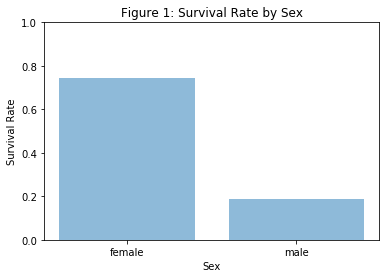

In [11]:
show_stats_bar_chart_single_factor(titanic_df, 'Sex')

age_grp
00-04                (27, 40, 0.675)
05-09                  (11, 22, 0.5)
10-14                (7, 16, 0.4375)
15-19       (34, 86, 0.395348837209)
20-24      (39, 114, 0.342105263158)
25-29      (38, 106, 0.358490566038)
30-39      (73, 167, 0.437125748503)
40-49        (34, 89, 0.38202247191)
50+         (27, 74, 0.364864864865)
Unknown    (52, 177, 0.293785310734)
dtype: object
---------------------------------
Printing stats for factor: age_grp
Factor age_grp statistically signif, test statistic: 25.71, upper threshold: 19.02, lower threshold: 2.70


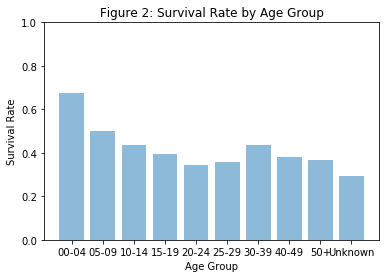

In [12]:
show_stats_bar_chart_single_factor(titanic_df, 'age_grp', grp_name="Age Group")

Again as expected, in <i>Figure 2</i> (above) we see an effect of age, both in the statistical test, and with the bar charts showing the highest rate for children.  We do not see any significant change for older passengers, so it does not look like there were any apparent costs or benefits of being elderly.  Taking out the "Unknown" age group for passengers without a given age, we still have statistical significance (see below).

In [13]:
print_stats(titanic_df.query('age_grp != "Unknown"'), 'age_grp')

Printing stats for factor: age_grp
Factor age_grp statistically signif, test statistic: 18.99, upper threshold: 17.54, lower threshold: 2.18


age_grp  Sex   
00-04    female     (12, 17, 0.705882352941)
         male       (15, 23, 0.652173913043)
05-09    female      (7, 13, 0.538461538462)
         male         (4, 9, 0.444444444444)
10-14    female       (5, 9, 0.555555555556)
         male         (2, 7, 0.285714285714)
15-19    female     (29, 36, 0.805555555556)
         male                   (5, 50, 0.1)
20-24    female     (32, 42, 0.761904761905)
         male       (7, 72, 0.0972222222222)
25-29    female     (20, 30, 0.666666666667)
         male       (18, 76, 0.236842105263)
30-39    female     (50, 60, 0.833333333333)
         male      (23, 107, 0.214953271028)
40-49    female             (22, 32, 0.6875)
         male       (12, 57, 0.210526315789)
50+      female     (20, 22, 0.909090909091)
         male        (7, 52, 0.134615384615)
Unknown  female     (36, 53, 0.679245283019)
         male      (16, 124, 0.129032258065)
dtype: object
---------------------------------


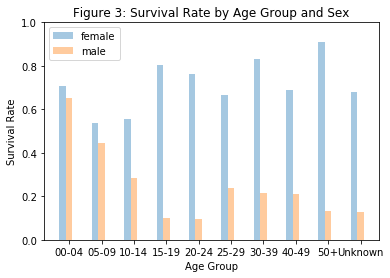

In [14]:
show_stats_bar_chart_two_factors(titanic_df, ['age_grp', 'Sex'], grp1Name = "Age Group")

Here we can see in <i>Figure 3</i> above some distinct differences between males and females regarding when survival rates went up or down depending on age.  For females, it seems survival rates were actually <i>worse</i> at ages 5-14 compared to ages 15+, with just 12 out 22 passengers surviving, a survival rate less than the 74% for all female passengers (see below).  This would warrant further study.  <br>
Males, on the other hand, saw survival rate drop even starting at ages 5-9, and dropping more each age group until bottoming out around 10% at ages 15-24.<br>
We now look at survival rates for passengers sharing a ticket with a survivor, starting in <i>Figure 4</i> below.

Sex
female    (106, 108, 0.981481481481)
male        (41, 94, 0.436170212766)
dtype: object
---------------------------------
Printing stats for factor: Sex
Not enough data


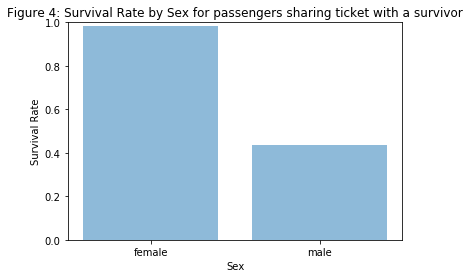

In [15]:
show_stats_bar_chart_single_factor(titanic_df.query("surv_ticket == True"), 
                                   'Sex', sample_pop="passengers sharing ticket with a survivor")

Here we can see that the major differences in survival depending on sex continue when looking at passengers sharing a ticket with a survivor.  In fact, females survive at a very high rate of 98%, whereas for males it is only 43% <br>
This is as predicted, from the intuitions based on the Wikipedia mini-sample.  <br>
<i>Notice that survival rate for males seen here is much higher than for the baseline 19% for all male passengers </i>(not just those sharing a ticket with a survivor).  <i>This is somewhat a surprise,</i> as the brief look at the Wikipedia data showed what looked like an even lower survival rate.  In retrospect, however, this makes sense as we would not expect every or even most adult males to relinquish the chance to be saved if they (and a family member) had the opportunity. <br>
<i>Note this leaves out of the analysis all the females aged 5-14 who did not survive despite their young age.</i>  There were 10 (out of 22) females in this age range who did not survive, but only 2 (out of 108) females did not survive among all females sharing a ticket with a survivor.  So all or almost all of the girls (and women) who did not survive did not have a ticket in which another survived.  Unlike the males, for the most part <i>the females on a shared ticket all survived together or all perished together.</i> <br>
<i>This is a limitation of this approach centered on tickets held by a survivor.</i>  It might give insight to why some males might survive or not, but unfortunately it turns out it cannot tell us much about why a female may or may not have survived.

age_grp
00-04              (11, 11, 1.0)
05-09               (3, 4, 0.75)
10-14     (2, 3, 0.666666666667)
15-19     (1, 6, 0.166666666667)
20-24     (1, 3, 0.333333333333)
25-29    (4, 12, 0.333333333333)
30-39             (9, 24, 0.375)
40-49    (4, 11, 0.363636363636)
50+                (1, 8, 0.125)
dtype: object
---------------------------------
Printing stats for factor: age_grp
Not enough data


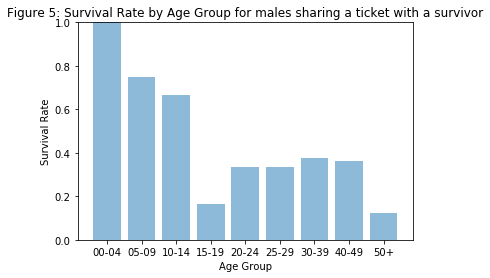

In [16]:
show_stats_bar_chart_single_factor(titanic_df.query('Sex == "male" & surv_ticket == True & age_grp != "Unknown"'), 
                                   'age_grp', grp_name="Age Group", sample_pop="males sharing a ticket with a survivor")

Looking at the bar chart in <i>Figure 5</i> and the group-by readout, we see a dropoff of survival rate for males at age 15+.  Looking more closely at the group-by readout, we see there are just 2 males less than 10 years sharing a ticket with a survivor who did not survive, and then the survival dropped for the age group 15-19 years.  <br>

It was more common in the days of the Titanic for males in the teenage years to be treated as men, and these results seem to reflect that.  <i>So, consistent with the "women and children first" principle, we see male children doing better especially if we consider males 15-19 years old to be "men".</i>  However, to follow the common standard we will treat males as men after reaching the age of 18 in the future queries.<br>

We can summarize these findings for sex and age of passengers sharing a ticket with a survivor in the  pie chart below (<i>Figure 6</i>), looking in particular at those who did NOT survive despite sharing a ticket with a survivor.

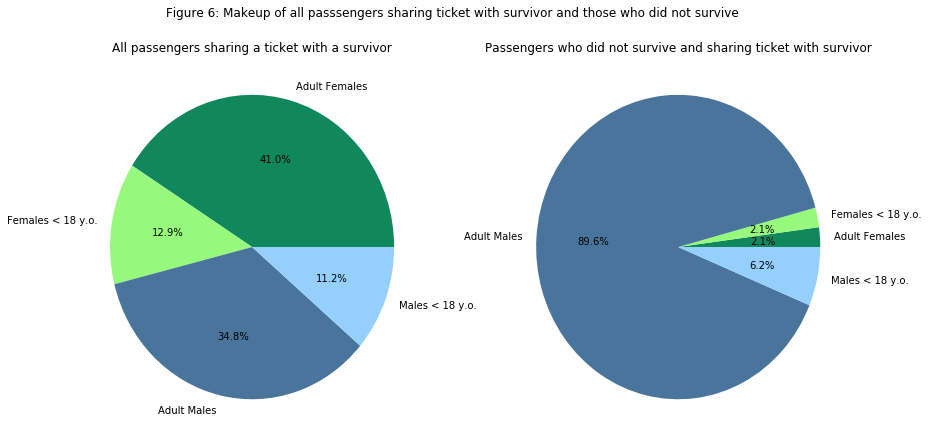

In [17]:
# pie chart

age_filter = titanic_df['Age'].apply(lambda x: not isnan(x)) # need filter to prevent NaN ages grouped with other ages < 18

surv_tickets = list(titanic_df[age_filter].query('surv_ticket == True').
                    groupby(['Sex', titanic_df[age_filter]['Age'] < 18]).size())
surv_tickets_didnt_surv = list(titanic_df[age_filter].query('surv_ticket == True & Survived == 0').
     groupby(['Sex', titanic_df[age_filter]['Age'] < 18]).size())

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
labels = "Adult Females", "Females < 18 y.o.", "Adult Males", "Males < 18 y.o."
colors = ['xkcd:dark sea green', 'xkcd:light green', 'xkcd:dull blue', 'xkcd:light blue']
ax1.pie(surv_tickets, labels=labels, autopct='%1.1f%%', colors=colors)
ax1.set_title('All passengers sharing a ticket with a survivor')
ax2.pie(surv_tickets_didnt_surv, labels=labels, autopct='%1.1f%%', colors=colors)
ax2.set_title('Passengers who did not survive and sharing ticket with survivor')
mainTitle = 'Figure {}: Makeup of all passsengers sharing ticket with survivor and those who did not survive'.format(_FigureNum)
_FigureNum += 1
plt.suptitle(mainTitle)

<br>
The comparison is striking.  As expected, we see that almost all the passengers who did not survive despite sharing a ticket 
with a survivor were overwhelmingly male (~96%), mostly adult males (~90%).  This is consistent with the predictions made that
were based on the brief look at the Wikipedia survival data for a few families.  <br>

<i>In general, we can reason that if passengers shared a ticket with a survivor, they likely all had an opportunity to survive, </i>
since we wouldn't expect such a high survival rate for all the females otherwise; it must have been possible to selectively 
board certain passengers on the lifeboats among the groups with survivors.

<h3><i>Analysis for oldest males and number of passengers in shared ticket</i></h3>
<h4><I>Oldest male in ticket </I></h4><br>
Now we look at the older males sharing a ticket with survivors.  We see (<i>Figure 7</i>, below) that, <i>somewhat as predicted, oldest males sharing a ticket (not necessarily with a survivor) have a (somewhat) lower survival rate </i>compared to all males sharing a ticket, although this difference is not statistically significant by the custom made chi-square test.  (We note in passing that if we include all males 15 years and older in the sample, which is about when survival rates started to drop, our chi-squared test metric increases from 1.33 to 3.01, but this still does not approach statistical significance for two tailed test with alpha=.05; not shown)  <br>

Also, <i>consistent with predictions, in Figure 8 we see that older males sharing a ticket with a survivor definitely appeared to do worse </i>compared to all males sharing a ticket with a survivor (26% compared to 56% survival rate).  However, again this interpretation needs caution because the chi-square test could not be run as usual due to less than 5 members in one contingency table cell.  <br>

If we ignored the lack of results from the chi-square tests and look just at the charts and group-by data, this would be in line with the predictions based on the assumption that being an older male would more likely lead to following the "women and children first" norm, especially among adult males sharing a ticket with a survivor.  Since we are not doing a rigorous statistical data analysis, we are fine with this interpretation as long as we bear in mind the lack of rigor and qualitative nature in these inferences.

oldest_male
0     (6, 20, 0.3)
1    (15, 75, 0.2)
dtype: object
---------------------------------
Printing stats for factor: oldest_male
Factor oldest_male NOT statistically signif, 1.33 < 5.02 and 1.33 > 0.00


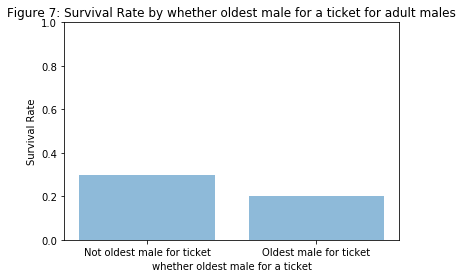

In [18]:
show_stats_bar_chart_single_factor(titanic_df.query('Age >= 18 & Sex == "male" & num_in_ticket > 0'), 
                                   'oldest_male', 
                                   grp_name='whether oldest male for a ticket',
                                   grpLabels=['Not oldest male for ticket', 'Oldest male for ticket'], 
                                   sample_pop="adult males")

oldest_male
0      (5, 9, 0.555555555556)
1    (14, 53, 0.264150943396)
dtype: object
---------------------------------
Printing stats for factor: oldest_male
Not enough data


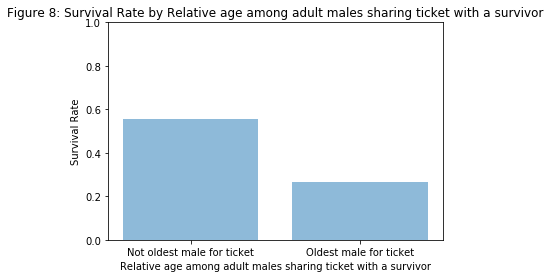

In [19]:
# oldest male 1x, surv ticket
show_stats_bar_chart_single_factor(titanic_df.query('Age >= 18 & surv_ticket == True & Sex == "male"'), 
                                   'oldest_male', 
                                   grp_name='Relative age among adult males sharing ticket with a survivor',
                                   grpLabels=['Not oldest male for ticket', 'Oldest male for ticket'])

<h4><i>Number of passengers sharing ticket</i></h4>

Now, on to the treatment of the number of passengers sharing a ticket as a factor for survival, which we guessed might be associated with a higher likelihood of following the "women and children first" rule. <br> 
We do see a lower chance of survival among all passengers with a high number of passengers (4+) sharing the ticket (<i>Figure 9</i>).  But, counter to expectations, this did not hold for adult males.</i>(See <i>Figure 10</i>). In fact, we have the survival rates (marginally) increasing with increasing number of passengers sharing the ticket.  <i>This is the opposite outcome of the predictions.</i><br>
And finally, in <i>Figure 11</i> we see that among male passengers sharing a ticket with a survivor, having a large number of passengers sharing the ticket actually <i>helped</i> at the highest (4+) level, again counter to the predictions.

num_in_ticket
1    (108, 188, 0.574468085106)
2     (66, 107, 0.616822429907)
3       (5, 49, 0.102040816327)
dtype: object
---------------------------------
Printing stats for factor: num_in_ticket
Factor num_in_ticket statistically signif, test statistic: 39.77, upper threshold: 7.38, lower threshold: 0.05


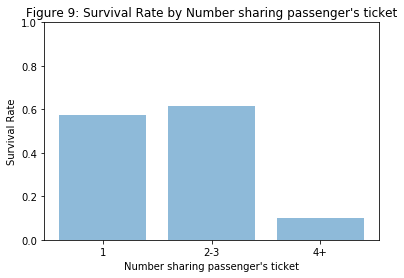

In [20]:
show_stats_bar_chart_single_factor(titanic_df.query('num_in_ticket > 0'), 
                                   'num_in_ticket', 
                                   grp_name="Number sharing passenger's ticket",
                                   grpLabels=['1', '2-3', '4+'])

num_in_ticket
1              (12, 60, 0.2)
2              (6, 24, 0.25)
3    (3, 11, 0.272727272727)
dtype: object
---------------------------------
Printing stats for factor: num_in_ticket
Not enough data


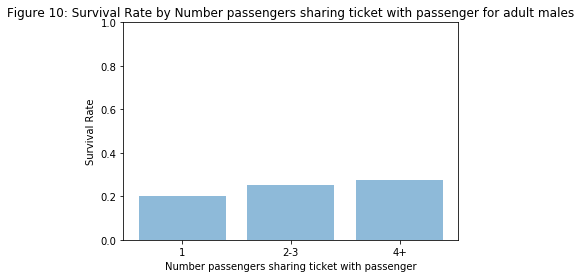

In [21]:
show_stats_bar_chart_single_factor(titanic_df.query('Age >= 18 & Sex == "male" & num_in_ticket > 0'), 
                                   'num_in_ticket', 
                                   grp_name='Number passengers sharing ticket with passenger', 
                                   grpLabels=['1', '2-3', '4+'],
                                   sample_pop="adult males")

num_in_ticket
1    (11, 36, 0.305555555556)
2     (5, 22, 0.227272727273)
3                (3, 4, 0.75)
dtype: object
---------------------------------
Printing stats for factor: num_in_ticket
Not enough data


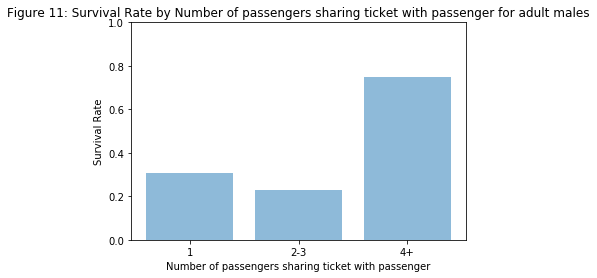

In [22]:
show_stats_bar_chart_single_factor(titanic_df.query('Age >= 18 & Sex == "male" & surv_ticket == True'), 
                                   'num_in_ticket', 
                                   grp_name='Number of passengers sharing ticket with passenger',
                                   grpLabels=['1', '2-3', '4+'], 
                                   sample_pop="adult males")

We take a closer look at this factor (number of passengers sharing ticket) to see if we can get a better sense of what is going on to explain these failed predictions.   <br> 
Digging around some, eventually we see (group-by readout below) that there is a problematic confounding of being a 3rd class passenger with having a high number of passengers sharing a ticket.

In [23]:
# what is the composition in terms of passenger class and sex for the highest level of number passengers sharing the ticket?
titanic_df.query('num_in_ticket == 3').groupby(['Pclass', 'Sex']).size()

Pclass  Sex   
2       male       5
3       female    15
        male      29
dtype: int64

What we see is that <i>passengers having 3+ passengers sharing a ticket are overwhelmingly 3rd class passengers, </i>which would be likely to have lower survival rate, or 2nd class male passengers, which are also known to have low survival rate, lower than 3rd class males.  As we are not looking into the effect of passenger class, we only note these facts rather than chart and analyze them. (See the Wikipedia reference mentioned earlier for more details)<br>
<i>So it turns out that looking at the number of passengers sharing a ticket with the passenger may be telling us more about passenger class than about the "women and children first" effect on survival. </i> <br>
Moreover, when we look at how this factor affects women, we notice that for the highest level of number passengers sharing the ticket (4+), all 15 out of 15 female passengers perished. (See <i>Figure 12</i>). This is unexpected, and without a good explanation for anything we have seen so far.  <i>Again it appears that our variable is doing something else than tracking the "women and children first" effect. </i>


num_in_ticket
1    (83, 102, 0.813725490196)
2     (50, 63, 0.793650793651)
3                 (0, 15, 0.0)
dtype: object
---------------------------------
Printing stats for factor: num_in_ticket
Not enough data


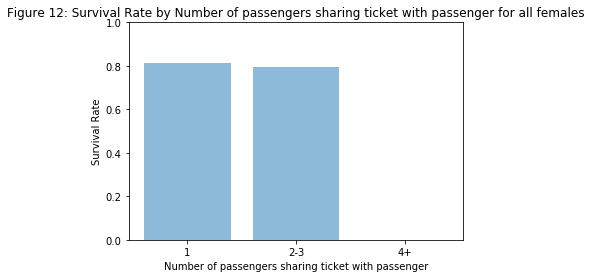

In [24]:
show_stats_bar_chart_single_factor(titanic_df.query('Sex == "female" & num_in_ticket> 0'), 
                                   'num_in_ticket', 
                                   grp_name='Number of passengers sharing ticket with passenger',
                                   grpLabels=['1', '2-3', '4+'], 
                                   sample_pop="all females")

<h3><i>Analysis of # parents/children</i></h3>

Perhaps we will have better luck with another variable that would better represent 
what we are looking for, the number of children and parents (the "Parch" column in the data). With more children possibly taking up seats in the lifeboats, there would be more pressure on the adult men to follow "women and children first", resulting in lower survival rates for adult men.<br>
A similar argument might be made for the number of siblings or spouses, which is another column in the data.  But this might not matter as much to the adult males as their number of children.  A sibling of an adult male would be like an extra aunt or uncle, who we would guess would be less likely than a child to be tied to the same same ticket.  <br>
At any rate, in the interest of space we just analyze the number of parents and children, making the same predictions as were made for number of passengers sharing the ticket:  <b>higher amount of parents/children associated with lower survival rate among all men and men sharing a ticket with a survivor;</b>  additionally, if this seems tied to the "women and children first rule", then we also predict that <b>being the oldest male would have its biggest impact on those men with larger number of parents and children.</b>

<i>First, a look at the effect of number parents/children on the survival rate of all passengers:</i>

parch_grp
0    (233, 678, 0.343657817109)
1     (65, 118, 0.550847457627)
2      (44, 95, 0.463157894737)
dtype: object
---------------------------------
Printing stats for factor: parch_grp
Factor parch_grp statistically signif, test statistic: 21.78, upper threshold: 7.38, lower threshold: 0.05


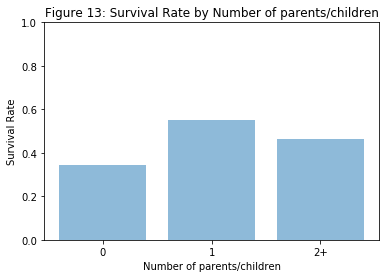

In [25]:
show_stats_bar_chart_single_factor(titanic_df, 'parch_grp', 
                                   grp_name='Number of parents/children',
                                   grpLabels=['0', '1', '2+'])

From the <i>Figure 13</i> and stats read out above, we see the # parents/children is a significant 
factor for <i>all passengers</i>, with having 1 parent or child being the most favorable, followed by 2+.  <BR>

In <i>Figure 14</i>, we see in the chart below that the number of parents/children apparently may have some effect with survival rate going (slightly) down with increasing number parents/children, in line with predictions.  Again, though, we must remember that there is not enough data to run a proper chi-square test, so we cannot rule out chance for the results.<BR>

In <i>Figure 15</i>, looking at adult males sharing ticket with survivor, we see results qualitatively in line with the predictions.  The survival rate goes down with each level increase of # parents/children, but again without enough data to be very confident in this interpretation.

parch_grp
0    (64, 353, 0.181303116147)
1      (5, 30, 0.166666666667)
2     (1, 12, 0.0833333333333)
dtype: object
---------------------------------
Printing stats for factor: parch_grp
Not enough data


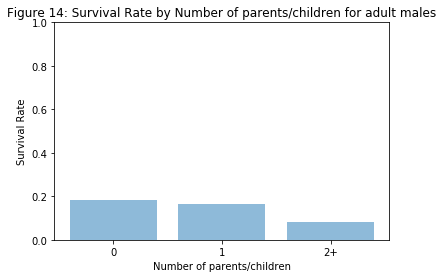

In [26]:
show_stats_bar_chart_single_factor(titanic_df.query('Sex == "male" & Age >= 18'), 
                                   'parch_grp', 
                                   grp_name='Number of parents/children',
                                   grpLabels=['0', '1', '2+'], sample_pop="adult males")

parch_grp
0    (15, 39, 0.384615384615)
1                (3, 15, 0.2)
2               (1, 8, 0.125)
dtype: object
---------------------------------
Printing stats for factor: parch_grp
Not enough data


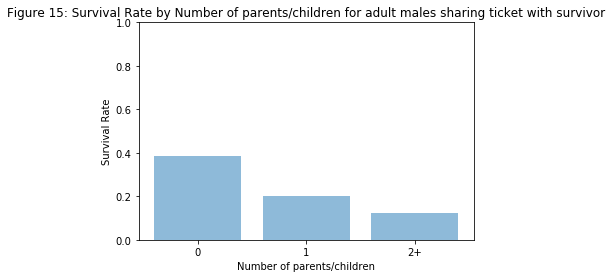

In [27]:
show_stats_bar_chart_single_factor(titanic_df.query('surv_ticket == True & Sex == "male" & Age >= 18'), 
                                   'parch_grp', 
                                   grp_name='Number of parents/children',
                                   grpLabels=['0', '1', '2+'], 
                                   sample_pop="adult males sharing ticket with survivor")

Finally, we look below (<i>Figure 16</i>) at how being the oldest male might affect survivability for all males across the 
levels for # parents/children. <BR>
We see that being an older male does not seem to matter if there are no parents/children, but otherwise it does matter.  <i>The results are somewhat different than expected since we predicted the effect of being an older male would increase with increasing number parents/children</i>, whereas there does not seem to be a difference here between the two non-zero levels.  <br>
This, together with the results above for men sharing a ticket with a survivor, suggests that <i>what
matters in regards to being the oldest male is whether the man is single vs. having a family.</i>  This is still consistent with the 
"women and children first" rule playing a role, just differently than we originally
expected.  In this interpretation, <i>men with a family, especially the oldest men sharing a ticket,
are more likely to relinquish a chance to be rescued.</i>

parch_grp  oldest_male
0          0              (10, 38, 0.263157894737)
           1              (11, 48, 0.229166666667)
1          0              (13, 24, 0.541666666667)
           1               (3, 22, 0.136363636364)
2          0               (8, 22, 0.363636363636)
           1                          (1, 10, 0.1)
dtype: object
---------------------------------


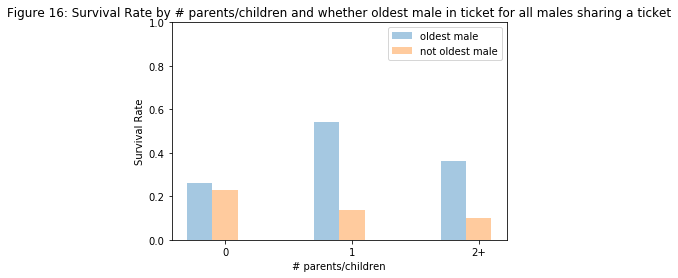

In [28]:
# We might see an effect of oldest male on parch 
show_stats_bar_chart_two_factors(titanic_df.query('num_in_ticket > 0 & Sex == "male"'), 
                                 ['parch_grp', 'oldest_male'], 
                                 grp1Name="# parents/children", 
                                 grp2Name="whether oldest male in ticket",
                                 grp1Labels=['0', '1', '2+'],
                                 grp2Labels=['oldest male', 'not oldest male'],
                                 sample_pop="all males sharing a ticket")

<h3><i>Summary and Conclusion</i></h3>

We summarize the results of the previous predictions:

<li>As expected, males had lower survival rate than females, and children higher survival rates than adults.
<li>Men sharing a ticket with a survivor had a low survival rate, consistent with predictions, but had a higher survival rate than the baseline for all male passengers, contrary to predictions.
<li>Females sharing a ticket with a survivor had a very high survival rate, consistent with predictions.
<li>Among those who did not survive and shared a ticket with a survivor, a very high percentage (around 96%) were males, with most of these adult males (~90%).  This is consistent with predictions, and perhaps one of the best illustrations of the "women and children first" effect.
<li>For all men sharing a ticket, being the oldest male appeared to negatively affect survival, especially among those sharing a ticket with a survivor, consistent with predictions.  However, with limited data there was no statistical significance and so these results should be interpreted with caution.
<li>For all passengers sharing a ticket, having the highest number of passengers sharing the ticket appeared to negatively affect survival.  However, this was not true for adult males, contrary to predictions.  Looking further into this factor, it was seen that tickets with a higher number of shared passengers were overwhelmingly 3rd class passengers, so this variable may say more about passenger class than propensity to follow "women and children first".

<li>For adult males, as predicted, an increasing number of parents/children appeared to lead to slightly lower chances of survival.  For adult males sharing a ticket with a survivor, having a larger number of passengers sharing the ticket did appear to negatively affect survival, in line with predictions.  It appeared that perhaps being a single male or not was what mattered the most, and it did appear that non-single males were more affected by being the oldest male, in line with predictions.  All of the findings have to taken with several grains of salt, since there was not enough data to put a lot of weight into this, let alone to run a chi-square test.

<i>Conclusion:</i>  <b>The majority of the predictions at the qualitative level were on the whole mostly born out by the data, with caveats for lack of statistical rigor due to sample sizes.</b>  We do see women and children at a higher survival rate than adult males, both in the titanic population as a whole and in the group of males sharing a ticket with a survivor.  Also, we saw that being the oldest male sharing the ticket and the number of passengers sharing the ticket may play a role, although the number of passengers sharing the ticket did not turn out to be as predictive as expected and indeed may be confounded with passenger class, as the tickets with the most passengers were overwhelmingly third class. On the other hand, the number parents/children did look like a potentially good predictor for lower survival with adult men, especially for adult men sharing a ticket with a survivor, and this was as predicted.  Finally, there was some data suggesting that being an older male was a vulnerability if you are not a single male (with no parents/children).  Again, the non-quantitative nature of these interpretations must be remembered.

For the main takeaway, the fact that so few women and children sharing a ticket with a survivor did not survive compared to men suggests that there was something going on that was somewhat "by design" and not just "by chance", and that was the "women and children first" norm.  <b>This suggests that sharing a ticket with a survivor is a meaningful unit of analysis, which is the biggest contribution of this analysis.</b>

These results could be extended by merging the Kaggle data with the Wikipedia data, which explicitly grouped passengers together but did not show the ticket numbers.  If the Kaggle and Wikipedia data were merged together, we would likely have a larger number of family groups which would allow us to ask questions that we could not answer due to lack of data.